In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Read
df = pd.read_csv('train.csv', names=["Date_Time", "y"], header=None )

df = df.iloc[1:]

df = df.dropna()

df['Date_Time'] = pd.to_datetime(df['Date_Time'],format='%d.%m.%y')
df['y'] = pd.to_numeric(df['y'])

df

,Date_Time,y
1,2015-01-01,1.91157
2,2015-02-01,1.44733
3,2015-03-01,1.89355
4,2015-04-01,2.03274
5,2015-05-01,2.27843
...,...,...
70,2020-10-01,2.21851
71,2020-11-01,2.01204
72,2020-12-01,1.97353
73,2021-01-01,2.19952


<AxesSubplot:xlabel='Date', ylabel='y'>

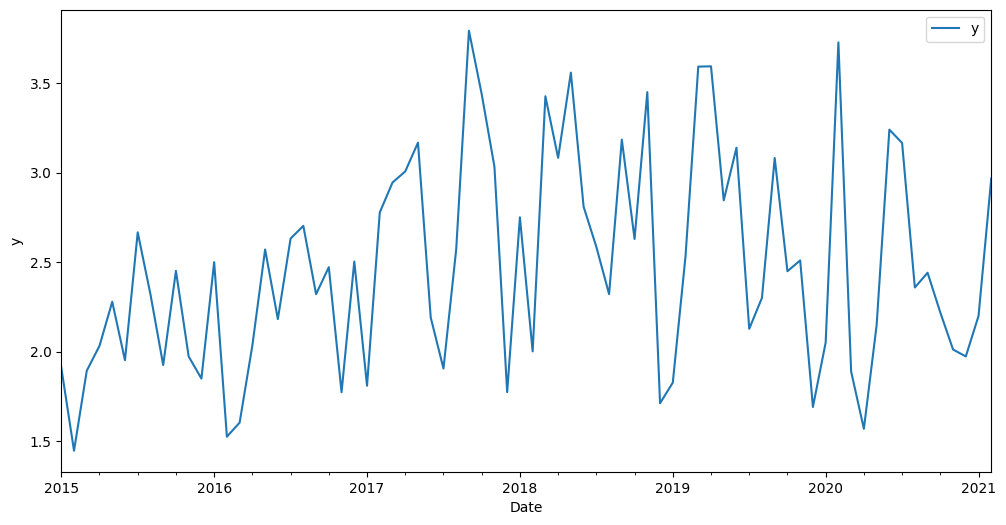

In [3]:
df.set_index('Date_Time').plot(figsize=(12,6), xlabel='Date', ylabel='y')

In [4]:
df_grouped = df.groupby(['Date_Time']).agg({'y': 'sum'})
df_grouped

,y
Date_Time,
2015-01-01,1.91157
2015-02-01,1.44733
2015-03-01,1.89355
2015-04-01,2.03274
2015-05-01,2.27843
...,...
2020-10-01,2.21851
2020-11-01,2.01204
2020-12-01,1.97353


In [5]:
y = df_grouped.squeeze() # prepare the data as a pandas Series
y

Date_Time
2015-01-01    1.91157
2015-02-01    1.44733
2015-03-01    1.89355
2015-04-01    2.03274
2015-05-01    2.27843
               ...   
2020-10-01    2.21851
2020-11-01    2.01204
2020-12-01    1.97353
2021-01-01    2.19952
2021-02-01    2.96740
Name: y, Length: 74, dtype: float64

In [6]:
df

,Date_Time,y
1,2015-01-01,1.91157
2,2015-02-01,1.44733
3,2015-03-01,1.89355
4,2015-04-01,2.03274
5,2015-05-01,2.27843
...,...,...
70,2020-10-01,2.21851
71,2020-11-01,2.01204
72,2020-12-01,1.97353
73,2021-01-01,2.19952


In [7]:
df

,Date_Time,y
1,2015-01-01,1.91157
2,2015-02-01,1.44733
3,2015-03-01,1.89355
4,2015-04-01,2.03274
5,2015-05-01,2.27843
...,...,...
70,2020-10-01,2.21851
71,2020-11-01,2.01204
72,2020-12-01,1.97353
73,2021-01-01,2.19952


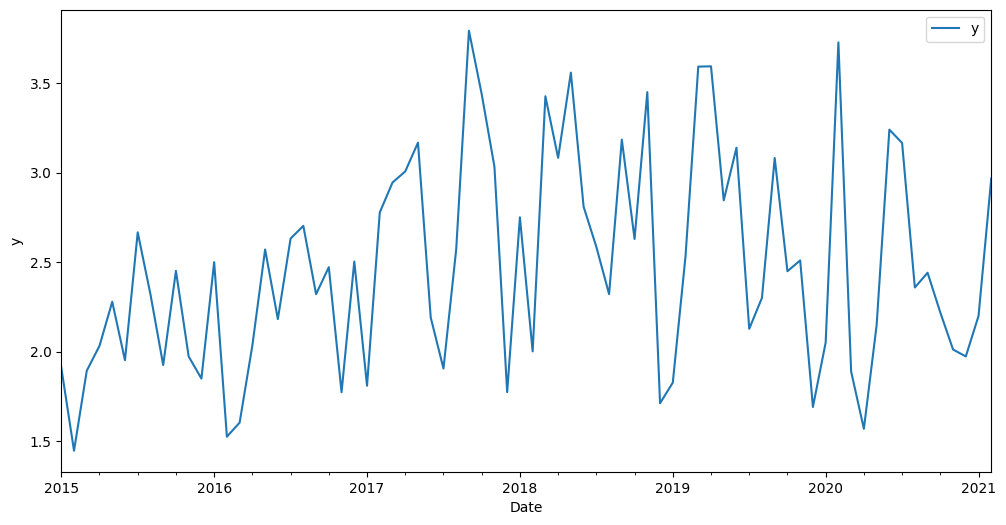

In [8]:
df.plot(x = "Date_Time", figsize=(12,6), xlabel='Date', ylabel='y')
plt.show()

### ¿stationary?

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_grouped.values.flatten())

print('ADF Statistic: %f' % result[0])
print(f"p-value: {result[1]}")

ADF Statistic: -6.156135
p-value: 7.360988139166811e-08


pvalue (0) < 0.05 -> null hypothesis can be rejected. ( Ho )

Ha  can be accepted -> the residue series is stationary.

Ho -> the residue series is not stationary.

### Our data seems appears to be stationary.

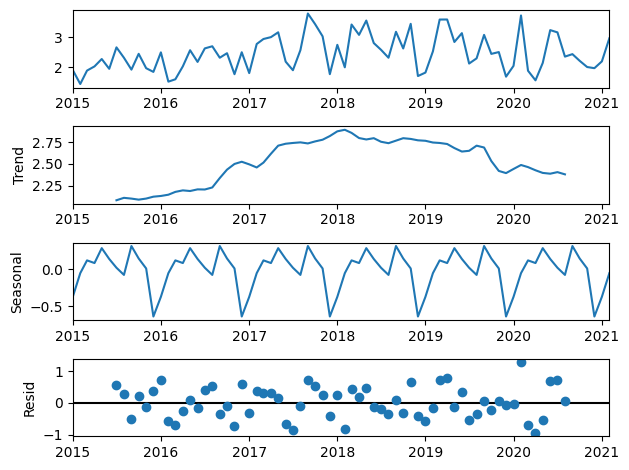

In [10]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposed = seasonal_decompose(df.set_index("Date_Time"), model='additive')

# Plot the decomposed time series
decomposed.plot();

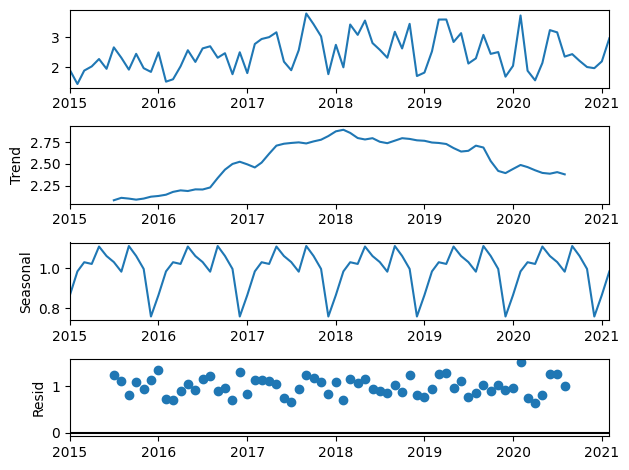

In [11]:
decomposed = seasonal_decompose(df.set_index("Date_Time"), model='multiplicable', period=12)

# Plot the decomposed time series
decomposed.plot();

<AxesSubplot:xlabel='Date_Time'>

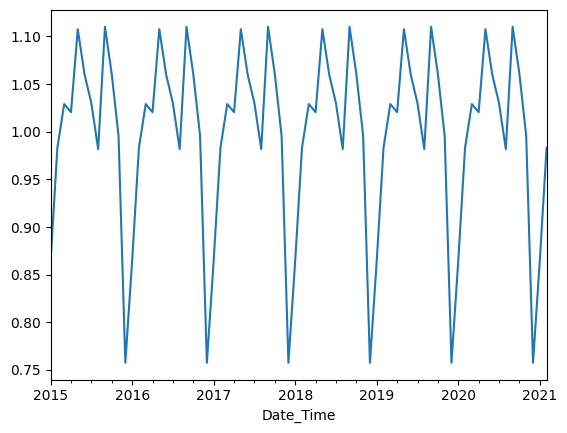

In [12]:
decomposed.seasonal.plot()

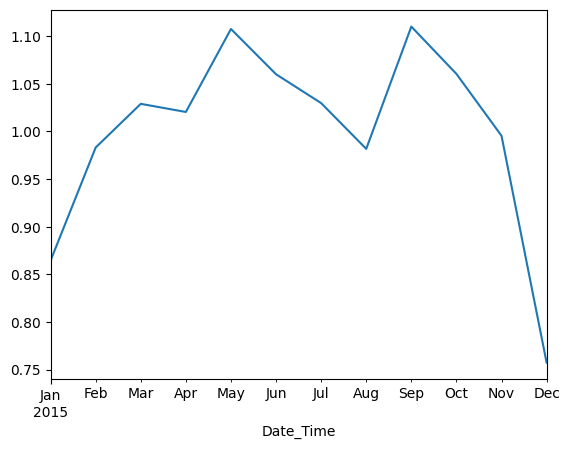

In [13]:
decomposed.seasonal["2015"].plot();

# End of year downturn, beginning of year recovery. the months of May and July there are peaks

<AxesSubplot:xlabel='Date_Time'>

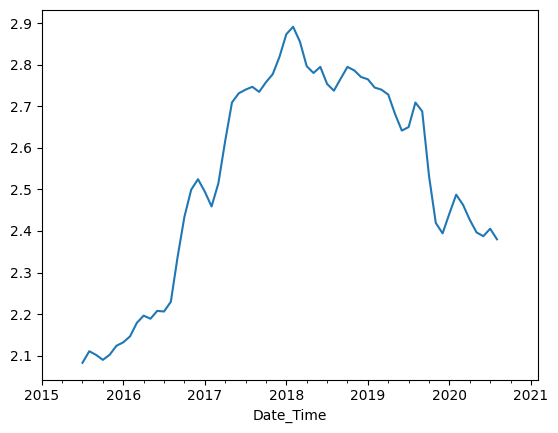

In [14]:
decomposed.trend.plot()

# It can be seen that the trend was upward until 2028, which begins in a downward trend.

<AxesSubplot:xlabel='Date_Time'>

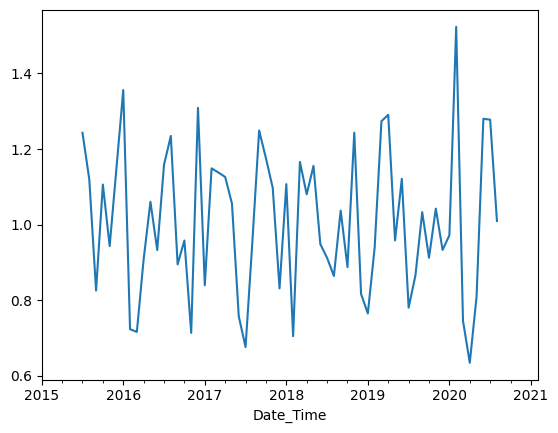

In [15]:
decomposed.resid.plot()

# Just highlight that it seems that at the beginning of 2020 there is a striking disturbance in the data, increasing the noise in that area (covid?)

In [16]:
y

Date_Time
2015-01-01    1.91157
2015-02-01    1.44733
2015-03-01    1.89355
2015-04-01    2.03274
2015-05-01    2.27843
               ...   
2020-10-01    2.21851
2020-11-01    2.01204
2020-12-01    1.97353
2021-01-01    2.19952
2021-02-01    2.96740
Name: y, Length: 74, dtype: float64

In [17]:
from sktime.datasets import load_airline
from sktime.transformations.series.lag import Lag

t = Lag(2)
Xt = t.fit_transform(y)

In [18]:
Xt

Date_Time
2015-01-01        NaN
2015-02-01        NaN
2015-03-01    1.91157
2015-04-01    1.44733
2015-05-01    1.89355
               ...   
2020-12-01    2.21851
2021-01-01    2.01204
2021-02-01    1.97353
2021-03-01    2.19952
2021-04-01    2.96740
Freq: MS, Name: y, Length: 76, dtype: float64

### Autocorrelation

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot:ylabel='y'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

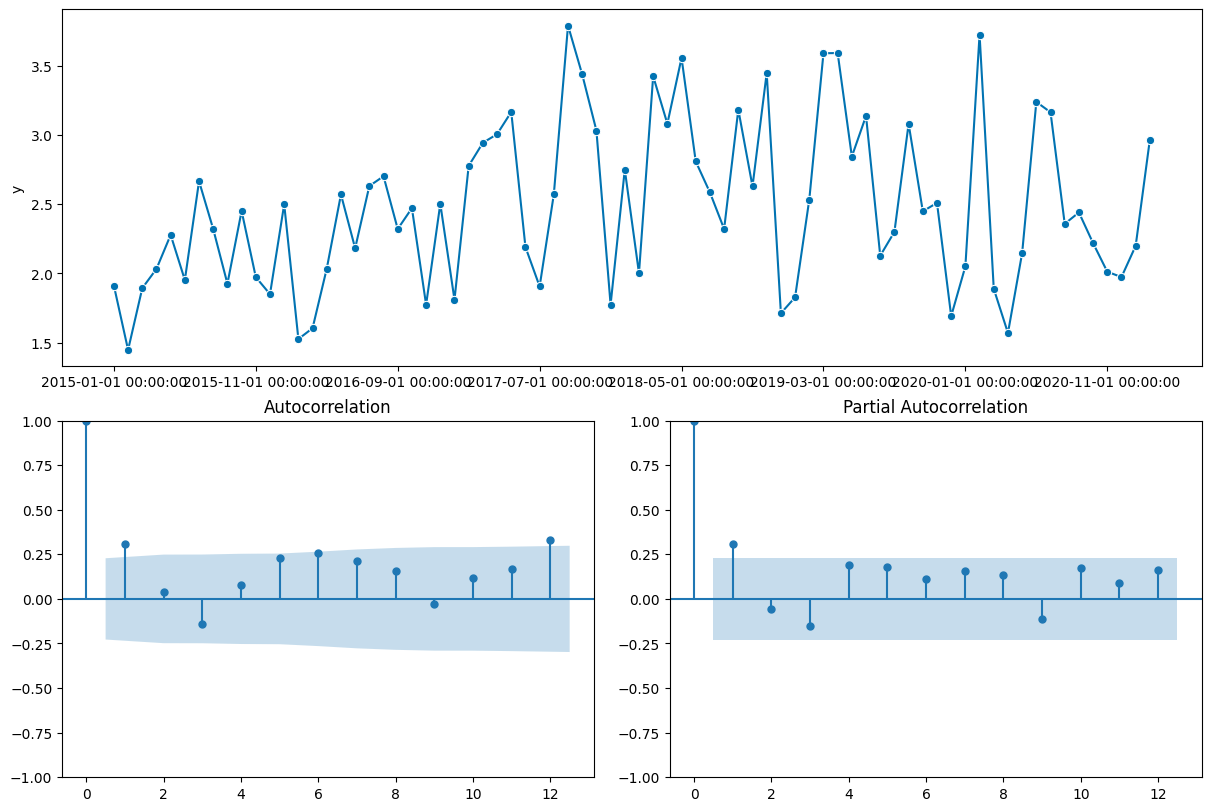

In [47]:
from sktime.utils.plotting import plot_correlations

plot_correlations(y, lags=12)

The autocorrelation confirms that we have a stationary time series. This is because the compensation with lag 1,2,3 is very low. In other words, y(t-1) does not depend on y(t-2).

In addition, the autocorrelation has two important peaks arround 1 and 12, that means that they are statistically significant.


ARIMA?

# the series contains seasonality but no trend (at least after 2018)

In [34]:
rolling_mean = df_grouped.rolling(7).mean()
rolling_std = df_grouped.rolling(7).std()

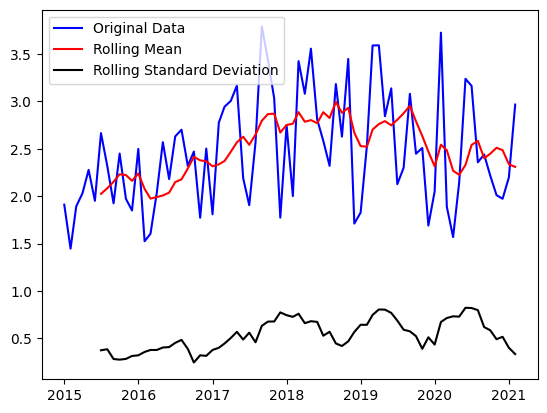

In [40]:
plt.plot(df_grouped, color="blue",label="Original Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
plt.legend(loc="best")





In [48]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df_grouped,autolag="AIC",maxlag=12)



In [49]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -6.156135e+00              Test Statistics
1  7.360988e-08                      p-value
2  0.000000e+00             No. of lags used
3  7.300000e+01  Number of observations used
4 -3.523284e+00          critical value (1%)
5 -2.902031e+00          critical value (5%)
6 -2.588371e+00         critical value (10%)


#  data is stationary (NO TREND)

In [ ]:
Como tneemos estacionalidad, es interesante trabajr con el moving average ya que captura estos patrones

5. Seasonal autoregressive integrated moving-average (SARIMA)

https://neptune.ai/blog/select-model-for-time-series-prediction-task


In [20]:
df

,Date_Time,y
1,2015-01-01,1.91157
2,2015-02-01,1.44733
3,2015-03-01,1.89355
4,2015-04-01,2.03274
5,2015-05-01,2.27843
...,...,...
70,2020-10-01,2.21851
71,2020-11-01,2.01204
72,2020-12-01,1.97353
73,2021-01-01,2.19952


In [21]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y.index, is_relative=False)
fh

ForecastingHorizon(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
 

In [22]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()